## Load data and modules

In [1]:
import os
import sys
from gears import PertData
import pandas as pd
import numpy as np
import torch
from anndata import AnnData

path = os.path.abspath('../sypp/src/gears/')
print(path)
sys.path.insert(0, path)

from mmd_loss import MMDLoss
from scipy.sparse import csr_matrix

/workspace/tfm/sypp/src/gears


In [2]:
!pwd

/workspace/tfm/cris_test


In [3]:
import train_predict_evaluate as gr

In [4]:
DATA_DIR_PATH = "data"
MODELS_DIR_PATH = "models"
RESULTS_DIR_PATH = "results"

PREDICT_SINGLE = False
PREDICT_DOUBLE = True
PREDICT_COMBO = False

split = "simulation"
seed = 7
hidden_size = 64
device = "cuda:0"
train_model = "gears_norman_split_{}_seed_{}_hidden_size_{}".format(split, str(seed), str(hidden_size))

print("Split: {}".format(split))
print("Seed: {}".format(seed))
print("Hidden size: {}".format(hidden_size))
print("Device: {}".format(device))
print("Model name: {}".format(train_model))

Split: simulation
Seed: 7
Hidden size: 64
Device: cuda:0
Model name: gears_norman_split_simulation_seed_7_hidden_size_64


In [5]:
print("Loading 'norman' data.")
norman = PertData(data_path=DATA_DIR_PATH)
norman.load(data_name="norman")



Found local copy...


Loading 'norman' data.


Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!


In [7]:
# Joining names after cleaning
splitting = norman.adata.obs['condition'].str.split('+')
for i in range(len(splitting)):
  if len(splitting[i]) == 2:
    if 'ctrl' in splitting[i]:
      splitting[i].remove('ctrl')

join_names = splitting.apply(lambda x: '+'.join(sorted(x)))
norman.adata.obs['condition_fixed'] = join_names

print(norman.adata.obs["condition_fixed"].value_counts())

ctrl             7353
KLF1             1641
BAK1             1171
CEBPE            1039
ETS2             1031
                 ... 
PLK4+STIL          66
SAMD1+TGFBR2       59
CEBPB+JUN          52
CBL+UBASH3A        50
C3orf72+FOXL2      49
Name: condition_fixed, Length: 231, dtype: int64


In [8]:
# Keeping only single perturbations
filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+") # mask for those NOT containing +
indexes_to_keep = filter_mask[filter_mask].index # mask that finds indeces in norman adata that aren't double perturbations
adata_single = norman.adata[indexes_to_keep].copy()

In [9]:
norman.adata = adata_single

In [10]:
norman.adata

AnnData object with n_obs × n_vars = 54931 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

In [ ]:
print("Preparing data split.")
norman.prepare_split(split=split, seed=seed)
norman.get_dataloader(batch_size=32)

# Viewing norman adata

In [6]:
adata = norman.adata
adata

View of AnnData object with n_obs × n_vars = 89357 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

In [49]:
adata.obsm["X_pca"]

array([[-1.2677131 ,  0.3949115 , -1.8902024 , ..., -0.35562468,
         0.7723939 ,  0.8741959 ],
       [ 4.022818  , -0.9024711 ,  1.4014624 , ...,  0.230336  ,
        -0.31203324, -0.9256998 ],
       [-1.3033295 ,  0.9107142 , -4.4119644 , ..., -1.2908779 ,
        -0.7256522 , -0.1357323 ],
       ...,
       [-0.34366938, -3.828863  , -2.655515  , ..., -0.9446328 ,
         0.20317978,  0.3438815 ],
       [ 2.8531785 , -0.42617828,  1.3527629 , ...,  0.26374182,
         0.1769151 , -0.51693   ],
       [-0.3083173 , -0.39469552, -2.7931988 , ..., -0.52865636,
         0.68107224, -0.30872697]], dtype=float32)

In [25]:
splitting = adata.obs['condition'].str.split('+')
for i in range(len(splitting)):
  if len(splitting[i]) == 2:
    if 'ctrl' in splitting[i]:
      splitting[i].remove('ctrl')

join_names = splitting.apply(lambda x: '+'.join(sorted(x)))
adata.obs['condition_fixed'] = join_names

print(adata.obs["condition_fixed"].value_counts())

ctrl             7353
KLF1             1641
BAK1             1171
CEBPE            1039
ETS2             1031
                 ... 
PLK4+STIL          66
SAMD1+TGFBR2       59
CEBPB+JUN          52
CBL+UBASH3A        50
C3orf72+FOXL2      49
Name: condition_fixed, Length: 231, dtype: int64


In [26]:
filter_mask = ~adata.obs["condition_fixed"].str.contains(r"\+") # mask for those NOT containing +
indexes_to_keep = filter_mask[filter_mask].index # mask that finds indeces in norman adata that aren't double perturbations
adata_single = adata[indexes_to_keep].copy()

In [69]:
# Number of top genes to select.
d = 200

# Compute the gene variances.
# axis=0 calculates variance along a column = var of each gene
gene_variances = adata_single.X.toarray().var(axis=0)  # type: ignore

# Sort the gene variances in descending order and get the indexes of the top d genes.
# [::-1] sorts all; -1 inverts sort (descending instead of ascending)
sorted_indexes = gene_variances.argsort()[::-1]

# Get the indexes of the top d genes (!!!!!!!!!!!!!!!!!)
top_gene_indexes = sorted_indexes[:d]

# Get the gene names of the top d genes.
top_genes = adata_single.var["gene_name"].iloc[top_gene_indexes]

# Get the variances of the top d genes. Before sorting.
top_variances = gene_variances[top_gene_indexes]

# Print the top d genes with the highest variances.
print(f"Top {d} genes with highest variances:")
for gene, variance in zip(top_genes, top_variances):
    print(f"{gene:15}: {variance:.2f}")

# Create a new AnnData object with only the top d genes.
adata_single_top_genes = adata_single[:, top_gene_indexes].copy()

Top 200 genes with highest variances:
HBZ            : 1.69
HIST1H4C       : 1.69
HBG2           : 1.15
HIST1H1C       : 0.85
HBG1           : 0.73
NEAT1          : 0.70
UBE2S          : 0.62
GYPB           : 0.61
MALAT1         : 0.58
TOP2A          : 0.57
VIM            : 0.57
HMGB2          : 0.56
SH3BGRL3       : 0.55
RP11-301G19.1  : 0.53
HIST1H2BJ      : 0.51
CENPF          : 0.49
GAL            : 0.48
MT-ND6         : 0.48
RP11-717F1.1   : 0.47
APOE           : 0.47
PTTG1          : 0.47
CKS1B          : 0.46
CKS2           : 0.46
TUBB           : 0.46
GYPA           : 0.46
KIAA0101       : 0.45
S100A11        : 0.45
PHF19          : 0.44
PSMA4          : 0.44
HNRNPH1        : 0.43
CACYBP         : 0.43
KRT18          : 0.43
LDHA           : 0.43
BTG1           : 0.43
CFD            : 0.42
SLC25A37       : 0.42
AIF1           : 0.42
LGALS1         : 0.41
NME1           : 0.41
HSPA8          : 0.41
BLVRB          : 0.41
HN1            : 0.41
SRM            : 0.41
MYL4           :

In [59]:
adata_subset.var

,gene_name
gene_id,
ENSG00000130656,HBZ
ENSG00000197061,HIST1H4C
ENSG00000196565,HBG2
ENSG00000187837,HIST1H1C
ENSG00000213934,HBG1
...,...
ENSG00000125148,MT2A
ENSG00000175130,MARCKSL1
ENSG00000145386,CCNA2


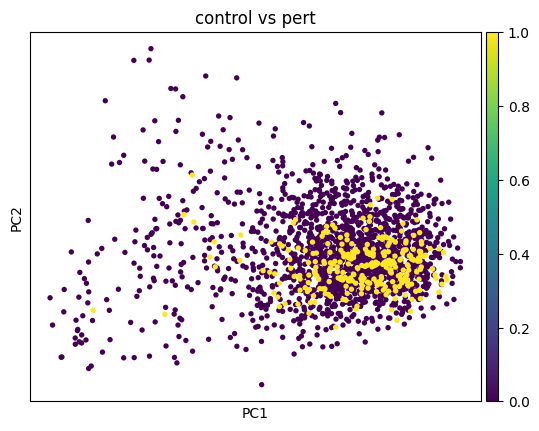

In [70]:
import scanpy as sc
subset_cells = np.random.choice(adata_single_top_genes.obs_names, size=2000, replace=False)
adata_subset = adata_single_top_genes[subset_cells, :]
sc.tl.pca(adata_subset)  # Recalculate PCA on the subset
sc.pl.pca(adata_subset, color="control", components=["1,2"], ncols=2, title="control vs pert")

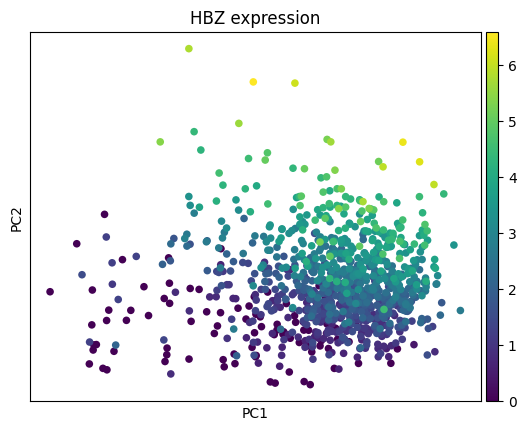

In [68]:
import scanpy as sc
subset_cells = np.random.choice(adata_single_top_genes.obs_names, size=1000, replace=False)
adata_subset = adata_single_top_genes[subset_cells, :]
sc.tl.pca(adata_subset)  # Recalculate PCA on the subset
sc.pl.pca(adata_subset, color="ENSG00000130656", components=["1,2"], ncols=2, title="HBZ expression")

In [ ]:
# gr.evaluate_double(adata=norman.adata, model_name=train_model)

Evaluating double 1/128: FOXA3+FOXA1
MMD (true vs. control):     0.301503
MMD (true vs. predicted):   6.048503
MSE (true vs. control):     0.086242
MSE (true vs. predicted):   0.057547
Evaluating double 2/128: SGK1+TBX2
MMD (true vs. control):     0.311693
MMD (true vs. predicted):   6.144230
MSE (true vs. control):     0.078591
MSE (true vs. predicted):   0.055485
Evaluating double 3/128: DUSP9+ETS2


: 

: 

: 

Evaluating double 1/128: FOXA3+FOXA1
MMD (true vs. control):     0.301503
MMD (true vs. predicted):   6.048503
MSE (true vs. control):     0.086242
MSE (true vs. predicted):   0.057547
Evaluating double 2/128: SGK1+TBX2
MMD (true vs. control):     0.311693
MMD (true vs. predicted):   6.144230
MSE (true vs. control):     0.078591
MSE (true vs. predicted):   0.055485
Evaluating double 3/128: DUSP9+ETS2

In [7]:
df = pd.read_csv(
        filepath_or_buffer="./results/gears_norman_split_simulation_seed_7_hidden_size_64_double.csv")
adata = norman.adata

In [7]:
# predict df has an extra double column
print(df.shape)
print(adata.shape)

(128, 5046)
(89357, 5045)


In [8]:
adata

View of AnnData object with n_obs × n_vars = 89357 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

In [9]:
df["double"]

0        FOXA3_FOXA1
1          SGK1_TBX2
2         DUSP9_ETS2
3      CDKN1C_CDKN1B
4        FOXA3_FOXL2
           ...      
123      FOXA1_FOXF1
124         IRF1_SET
125        CBL_PTPN9
126       CEBPB_OSR2
127       CBL_TGFBR2
Name: double, Length: 128, dtype: object

In [10]:
# SGK1_TBX2 is done correctly
# DUSP9_ETS2 crashes, >600 samples in norman.adata
double = "SGK1_TBX2"
pred_geps = df.loc[df["double"] == double]
pred_geps = pred_geps.iloc[0, 1:].tolist()


pred_geps = np.array([pred_geps])

In [11]:
pred_geps

array([[ 1.0962215e-21,  1.0269225e-01,  1.5303849e-01, ...,
         3.7186550e+00,  7.4551366e-03, -4.2565677e-25]])

In [12]:
pred_geps_copy = df.loc[df["double"] == double]

print(f"Evaluating double {df[df['double'] == double].index[0] + 1}/{len(df['double'])}: {double.replace('_', '+')}")
double = double.replace("_", "+")
true_geps = adata[adata.obs["condition"] == double]

if true_geps.n_obs>250:
    n = 250
    random_indices = np.random.choice(true_geps.n_obs, size=n, replace=False)
    true_geps = true_geps[random_indices, :]   
else:
    n = true_geps.n_obs
pred_geps_copy = pred_geps_copy.iloc[0, 1:].tolist()
pred_geps_copy = csr_matrix(np.tile(pred_geps, reps=(n, 1)))

Evaluating double 2/128: SGK1+TBX2


In [13]:
all_ctrl_geps = adata[adata.obs["condition"] == "ctrl"]
random_indices = np.random.choice(all_ctrl_geps.n_obs, size=n, replace=False)
ctrl_geps = all_ctrl_geps[random_indices, :]
pred_geps = csr_matrix(pred_geps)

In [14]:
print("Shape of true_geps: {}".format(true_geps.shape))
print("Shape of ctrl_geps: {}".format(pred_geps_copy.shape))
print("Shape of pred_geps: {}".format(pred_geps.shape))
print("Shape of pred_geps_copy: {}".format(pred_geps_copy.shape))

Shape of true_geps: (250, 5045)
Shape of ctrl_geps: (250, 5045)
Shape of pred_geps: (1, 5045)
Shape of pred_geps_copy: (250, 5045)


In [15]:
true_geps_tensor = torch.tensor(true_geps.X.toarray())
ctrl_geps_tensor = torch.tensor(ctrl_geps.X.toarray())
pred_geps_tensor = torch.tensor(pred_geps.toarray())
print("Shape of ctrl_geps_tensor: {} {}".format(ctrl_geps_tensor.shape[0], ctrl_geps_tensor.shape[1]))
print("Shape of pred_geps_tensor: {} {}".format(pred_geps_tensor.shape[0], pred_geps_tensor.shape[1]))
print("Shape of true_geps_tensor: {} {}".format(true_geps_tensor.shape[0], true_geps_tensor.shape[1]))

Shape of ctrl_geps_tensor: 250 5045
Shape of pred_geps_tensor: 1 5045
Shape of true_geps_tensor: 250 5045


In [16]:
pred_geps_tensor

tensor([[ 1.0962e-21,  1.0269e-01,  1.5304e-01,  ...,  3.7187e+00,
          7.4551e-03, -4.2566e-25]], dtype=torch.float64)

In [17]:
mmd_sigma = 200.0
kernel_num = 10
mmd_loss = MMDLoss(fix_sigma=mmd_sigma, kernel_num=kernel_num)

In [18]:
mmd_true_vs_ctrl = mmd_loss.forward(
                source=ctrl_geps_tensor, target=true_geps_tensor
            )

XX mean: 3.256816864013672
YY mean: 2.7831904888153076
2*XY mean: 5.699377059936523


In [19]:
mmd_true_vs_pred = mmd_loss.forward(
                source=pred_geps_tensor, target=true_geps_tensor
            )

XX mean: 10.0
YY mean: 2.783190601949038
2*XY mean: 6.7160238794992875


In [20]:
mse_true_vs_ctrl = torch.mean((true_geps_tensor - ctrl_geps_tensor) ** 2).item()
mse_true_vs_pred = torch.mean((true_geps_tensor - pred_geps_tensor) ** 2).item()

In [21]:
print(f"MMD (true vs. control):   {mmd_true_vs_ctrl:10.6f}")
print(f"MMD (true vs. predicted): {mmd_true_vs_pred:10.6f}")
print(f"MSE (true vs. control):   {mse_true_vs_ctrl:10.6f}")
print(f"MSE (true vs. predicted): {mse_true_vs_pred:10.6f}")


# print(f"{double},{n},{mmd_true_vs_ctrl},{mmd_true_vs_pred},{mse_true_vs_ctrl},{mse_true_vs_pred}",file=f)

MMD (true vs. control):     0.340631
MMD (true vs. predicted):   6.067167
MSE (true vs. control):     0.078852
MSE (true vs. predicted):   0.054228


## MMD and sample distribution

MMD, Max Mean Discrepancy, determines distance between distributions. MMD loss calculated above is particularly high because XX is not an actual distribution, it's just 1 point. When there is no variation to speak of in a sample group (in this case for prediction GEP), if there is an actual distance between points, 

In [22]:
# Increasing pred_gep size and adding some random noise
num = 100

double = "DUSP9_ETS2"
pred_geps_dist = df.loc[df["double"] == double]
pred_geps_dist = pred_geps_dist.iloc[0, 1:].tolist()
pred_geps_dist = csr_matrix(np.tile(pred_geps_dist, reps=(num, 1)))

# noise
noise = csr_matrix(1 + (np.random.randn(*pred_geps_dist[1:, :].shape) * 0.20))
pred_geps_dist = pred_geps_dist.toarray()
pred_geps_dist[1:, :] *= noise.toarray()

# new tensor
pred_geps_dist_tensor = torch.tensor(pred_geps_dist)

print("Shape of ctrl_geps_tensor: {} {}".format(ctrl_geps_tensor.shape[0], ctrl_geps_tensor.shape[1]))
print("Shape of pred_geps_tensor: {} {}".format(pred_geps_tensor.shape[0], pred_geps_tensor.shape[1]))
print("Shape of pred_geps_dist_tensor: {} {}".format(pred_geps_dist_tensor.shape[0], pred_geps_dist_tensor.shape[1]))
print("Shape of true_geps_tensor: {} {}".format(true_geps_tensor.shape[0], true_geps_tensor.shape[1]))

Shape of ctrl_geps_tensor: 250 5045
Shape of pred_geps_tensor: 1 5045
Shape of pred_geps_dist_tensor: 100 5045
Shape of true_geps_tensor: 250 5045


In [23]:
mmd_sigma = 200.0
kernel_num = 10
mmd_loss = MMDLoss(fix_sigma=mmd_sigma, kernel_num=kernel_num)

In [24]:
mmd_true_vs_ctrl = mmd_loss.forward(
                source=ctrl_geps_tensor, target=true_geps_tensor
            )

XX mean: 3.256816864013672
YY mean: 2.7831904888153076
2*XY mean: 5.699377059936523


In [25]:
mmd_true_vs_pred = mmd_loss.forward(
                source=pred_geps_tensor, target=true_geps_tensor
            )

XX mean: 10.0
YY mean: 2.783190601949038
2*XY mean: 6.7160238794992875


In [26]:
mmd_true_vs_pred_dist = mmd_loss.forward(
                source=pred_geps_dist_tensor, target=true_geps_tensor
            )

XX mean: 5.2856672548366275
YY mean: 2.783190601949038
2*XY mean: 6.625836981478683


In [27]:
mse_true_vs_ctrl = torch.mean((true_geps_tensor - ctrl_geps_tensor) ** 2).item()
mse_true_vs_pred = torch.mean((true_geps_tensor - pred_geps_tensor) ** 2).item()
mse_true_vs_pred_dist = torch.mean((true_geps_tensor[:num] - pred_geps_dist_tensor) ** 2).item() # MSE requires tensors to be same shape

In [28]:
print(f"MMD (true vs. control):   {mmd_true_vs_ctrl:10.6f}")
print(f"MMD (true vs. predicted): {mmd_true_vs_pred:10.6f}")
print(f"MMD (true vs. predicted_dist): {mmd_true_vs_pred_dist:10.6f}")
print(f"MSE (true vs. control):   {mse_true_vs_ctrl:10.6f}")
print(f"MSE (true vs. predicted): {mse_true_vs_pred:10.6f}")
print(f"MSE (true vs. predicted_dist): {mse_true_vs_pred_dist:10.6f}")

MMD (true vs. control):     0.340631
MMD (true vs. predicted):   6.067167
MMD (true vs. predicted_dist):   1.443021
MSE (true vs. control):     0.078852
MSE (true vs. predicted):   0.054228
MSE (true vs. predicted_dist):   0.056254


## MMD and bandwidth

Below: function to obtain all bandwidths and kernel for each one.

In [29]:
def gaussian_kernel_mmd_loss(
    source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None
):
    n_samples = int(source.size()[0]) + int(target.size()[0])
    batch_size = int(source.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(
        int(total.size(0)), int(total.size(0)), int(total.size(1))
    )
    total1 = total.unsqueeze(1).expand(
        int(total.size(0)), int(total.size(0)), int(total.size(1))
    )
    l2_distance = ((total0 - total1) ** 2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(l2_distance.data) / (n_samples**2 - n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    loss_list = []
    for bandwidth_temp in bandwidth_list:
        kernel = torch.exp(-l2_distance / bandwidth_temp)
        XX = kernel[:batch_size, :batch_size]  # noqa: N806
        YY = kernel[batch_size:, batch_size:]  # noqa: N806
        XY = kernel[:batch_size, batch_size:]
        loss = torch.mean(XX) + torch.mean(YY) - 2*torch.mean(XY)
        loss_list.append(loss)
    return bandwidth_list, loss_list

    

In [30]:
# Loss contribution of each kernel with pred_geps
mmd_sigma = 200.0
kernel_num = 10
bandwidth_list, loss_list_1 = gaussian_kernel_mmd_loss(source=pred_geps_tensor, target=true_geps_tensor,
                                                            kernel_num = kernel_num, fix_sigma=mmd_sigma)

In [31]:
# Loss contribution of each kernel with 100 pred_geps with random noise
bandwidth_list, loss_list_100 = gaussian_kernel_mmd_loss(source=pred_geps_dist_tensor, target=true_geps_tensor,
                                                            kernel_num = kernel_num, fix_sigma=mmd_sigma)

<function matplotlib.pyplot.show(close=None, block=None)>

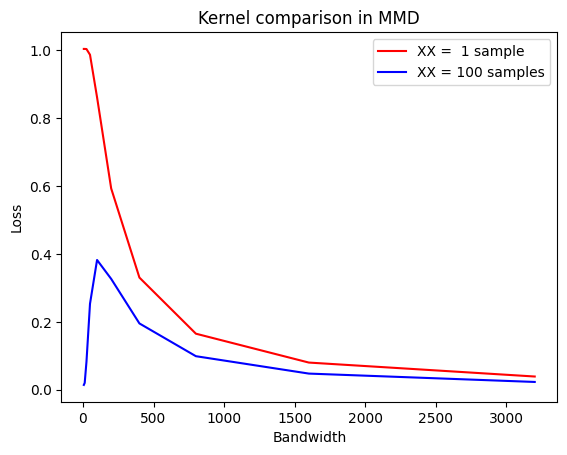

In [32]:
import matplotlib.pyplot as plt
plt.plot(bandwidth_list, loss_list_1, 'r-', label = "XX =  1 sample")
plt.plot(bandwidth_list, loss_list_100, 'b-', label = "XX = 100 samples")
plt.legend()
plt.title("Kernel comparison in MMD")
plt.xlabel("Bandwidth")
plt.ylabel("Loss")
plt.show

### Attempting MMD with all pred_geps vs. full set of true_geps

In [33]:
pred_geps_all = df.iloc[:, 1:]

In [35]:
double_indices = []
for double in df["double"]:
    double = double.replace("_", "+")
    true_geps_temp = adata[adata.obs["condition"] == double]
    random_index = np.random.choice(true_geps_temp.obs_names, size = 1, replace = False)
    double_indices.append(random_index[0])

In [37]:
true_geps = adata[double_indices].copy()

In [38]:
n = true_geps.n_obs
all_ctrl_geps = adata[adata.obs["condition"] == "ctrl"]
random_indices = np.random.choice(
    all_ctrl_geps.n_obs, size=n, replace=False
)
ctrl_geps = all_ctrl_geps[random_indices, :]

In [39]:
true_geps_tensor = torch.tensor(true_geps.X.toarray())
ctrl_geps_tensor = torch.tensor(ctrl_geps.X.toarray())
pred_geps_tensor = torch.tensor(pred_geps_all.values)

In [40]:
mmd_sigma = 100.0
kernel_num = 10
mmd_loss = MMDLoss(kernel_num=kernel_num)


In [41]:
mmd_true_vs_ctrl = mmd_loss.forward(
                source=ctrl_geps_tensor, target=true_geps_tensor
            )

XX mean: 4.239979267120361
YY mean: 3.600895643234253
2*XY mean: 7.638129711151123


In [42]:
mmd_true_vs_pred = mmd_loss.forward(
    source=pred_geps_tensor, target=true_geps_tensor
)

XX mean: 7.542480133442857
YY mean: 3.116010433686599
2*XY mean: 7.67836660081531


In [43]:
mse_true_vs_ctrl = torch.mean(
    (true_geps_tensor - ctrl_geps_tensor) ** 2
).item()
mse_true_vs_pred = torch.mean(
    (true_geps_tensor - pred_geps_tensor) ** 2
).item()

In [44]:
print(f"MMD (true vs. control):   {mmd_true_vs_ctrl:10.6f}")
print(f"MMD (true vs. predicted): {mmd_true_vs_pred:10.6f}")
print(f"MSE (true vs. control):   {mse_true_vs_ctrl:10.6f}")
print(f"MSE (true vs. predicted): {mse_true_vs_pred:10.6f}")


MMD (true vs. control):     0.202745
MMD (true vs. predicted):   2.980124
MSE (true vs. control):     0.080550
MSE (true vs. predicted):   0.053156


### Attempting MMD with substraction of pred_gep-ctrl_gep and true_gep-ctrl_gep

Trying: MMD </br>
True vs Predict as: </br>
true-control vs pred-control </br>
Control randomly sampled </br>
Usually in DEG analysis, the difference is measured wrt a control. In this case, we have an abundant sample size of control expression profiles. It might be worth a try to compute MMD as the discrepancy in two distributions of gene profiles over control.


In [11]:
# SGK1_TBX2 is done correctly
# DUSP9_ETS2 crashes, >600 samples in norman.adata
double = "SGK1_TBX2"
pred_geps = df.loc[df["double"] == double]
pred_geps = pred_geps.iloc[0, 1:].tolist()

pred_geps = np.array([pred_geps])

In [12]:
# print(f"Evaluating double {df[df['double'] == double].index[0] + 1}/{len(df['double'])}: {double.replace('_', '+')}")
double = double.replace("_", "+")
true_geps = adata[adata.obs["condition"] == double]

# Limiting n
if true_geps.n_obs>250:
    n = 250
    random_indices = np.random.choice(true_geps.n_obs, size=n, replace=False)
    true_geps = true_geps[random_indices, :]   
else:
    n = true_geps.n_obs

# Obtaining random sample of ctrl GEP
all_ctrl_geps = adata[adata.obs["condition"] == "ctrl"]
random_indices = np.random.choice(
    all_ctrl_geps.n_obs, size=n, replace=False
)
ctrl_geps = all_ctrl_geps[random_indices, :]
pred_geps = csr_matrix(np.tile(pred_geps, reps=(n, 1)))

# Another random ctrl_gep
random_indices_2 = np.random.choice(
    all_ctrl_geps.n_obs, size=n, replace=False
)
ctrl_geps_2 = all_ctrl_geps[random_indices_2, :]

# Tensor conversion and differential expression
ctrl_geps_tensor = torch.tensor(ctrl_geps.X.toarray())
ctrl_ctrl_geps_tensor = torch.tensor(ctrl_geps_2.X.toarray()) - ctrl_geps_tensor
true_ctrl_geps_tensor = torch.tensor(true_geps.X.toarray()) - ctrl_geps_tensor
pred_ctrl_geps_tensor = torch.tensor(pred_geps.toarray()) - ctrl_geps_tensor

# MMD
kernel_num = 10
sigma_num = 200
mmd_loss = MMDLoss(kernel_num=kernel_num, fix_sigma=sigma_num)

mmd_true_vs_ctrl = mmd_loss.forward(
                source=ctrl_ctrl_geps_tensor, target=true_ctrl_geps_tensor
            )

mmd_true_vs_pred = mmd_loss.forward(
    source=pred_ctrl_geps_tensor, target=true_ctrl_geps_tensor
)

# MSE
mse_true_vs_ctrl = torch.mean(
    (true_ctrl_geps_tensor - ctrl_ctrl_geps_tensor) ** 2
).item()
mse_true_vs_pred = torch.mean(
    (true_ctrl_geps_tensor - pred_ctrl_geps_tensor) ** 2
).item()

print(f"MMD (true vs. control):   {mmd_true_vs_ctrl:10.6f}")
print(f"MMD (true vs. predicted): {mmd_true_vs_pred:10.6f}")
print(f"MSE (true vs. control):   {mse_true_vs_ctrl:10.6f}")
print(f"MSE (true vs. predicted): {mse_true_vs_pred:10.6f}")

MMD (true vs. control):     0.166667
MMD (true vs. predicted):   0.571652
MSE (true vs. control):     0.080671
MSE (true vs. predicted):   0.053418
